In [ ]:
import torch
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

# Create an optimizer
initial_lr = 0.001
min_lr = 0.000001
optimizer = torch.optim.SGD([torch.randn(1, requires_grad=True)], lr= initial_lr)

# Define the number of epochs
num_epochs = 100
cycles = 4
# Learning rate schedulers
cosineAnnealingWarmRestarts = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=int(num_epochs/cycles), T_mult=1, eta_min=min_lr)
schedulers = {
    # "LambdaLR": lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch),
    # "MultiplicativeLR": lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.95),
    # "StepLR": lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1),
    # "MultiStepLR": lr_scheduler.MultiStepLR(optimizer, milestones=[30, 80], gamma=0.1),
    # "ConstantLR": lr_scheduler.ConstantLR(optimizer),
    # "LinearLR" : lr_scheduler.LinearLR(optimizer),
    # "ExponentialLR": lr_scheduler.ExponentialLR(optimizer, gamma=0.1),
    # "PolynomialLR": lr_scheduler.PolynomialLR(optimizer,total_iters=4, power=1.0),
    # "CosineAnnealingLR": lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0),
    "ChainedScheduler" : lr_scheduler.ChainedScheduler([lr_scheduler.ConstantLR(optimizer, total_iters=10), cosineAnnealingWarmRestarts]),
    # "SequentialLR": lr_scheduler.SequentialLR(optimizer, schedulers=[lr_scheduler.ConstantLR(optimizer, factor=0.1, total_iters=2), lr_scheduler.ExponentialLR(optimizer, gamma=0.9)], milestones=[2]),
    # "ReduceLROnPlateau": lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10),
    # "CyclicLR": lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=1, step_size_up=5, mode='triangular2'),
    # "OneCycleLR": lr_scheduler.OneCycleLR(optimizer, max_lr=1, total_steps=num_epochs),
    # "CosineAnnealingWarmRestarts": lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=int(num_epochs/cycles), T_mult=1, eta_min=min_lr)
}

# Create a plot for each scheduler
for name, scheduler in schedulers.items():
    lrs = []
    for epoch in range(num_epochs):
        optimizer.step()
        lrs.append(optimizer.param_groups[0]["lr"])
        if name != "ReduceLROnPlateau":
            scheduler.step()
        else:
            scheduler.step(epoch)  # Assume loss is decreasing with epoch for this example
        optimizer.zero_grad()

    plt.figure()
    plt.plot(lrs)
    plt.title(name)

plt.show()


You should consider upgrading via the '/Users/mnann/Documents/Code/AuthenticCursor/venvDev/bin/python -m pip install --upgrade pip' command.


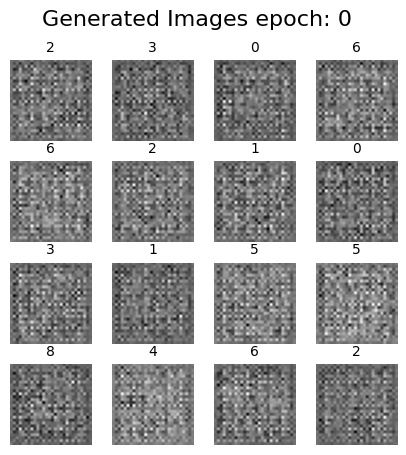

In [6]:

import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
os.system("pip install wandb")
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
import plotly.io as pio
import tempfile
from PIL import Image
import io
import wandb
import plotly.graph_objects as go
import torch.utils.data as data_utils

NUM_CLASSES = 10

class TempFileContext:
    def __enter__(self):
        self.tmp_file = tempfile.NamedTemporaryFile(suffix=".jpeg", delete=False)
        self.tmp_filename = self.tmp_file.name
        return self.tmp_filename

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.tmp_file.close()
        os.remove(self.tmp_filename)

# As per the DCGAN paper: All the weights are initialized from a zero centered normal distribution with standard deviation 0.02
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

import torch
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g, num_classes):
        """
        channels_noise: The size of the input noise vector. This noise vector is a random input from which the generator begins the generation of a new sample.
        channels_img: The number of output channels of the generator. This will typically be 1 for grayscale images or 3 for color (RGB) images.
        features_g: This is the base size of the feature maps in the generator. The number of neurons or nodes in each layer of the generator is a multiple of this base size.
        num_classes: The number of distinct classes or labels that the generator should generate images for. This is used to form the one-hot vector of class labels, which is concatenated to the noise vector to provide the generator with information about the class of image to generate.
        """
        super(Generator, self).__init__()
        self.channels_noise = channels_noise
        self.num_classes = num_classes

        self.gen = nn.Sequential(
            self.gen_block(channels_noise + num_classes, 256, kernel_size=7, stride=1, padding=0), # Append class labels to input noise.
            self.gen_block(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(128, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def gen_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, z):
        return self.gen(z)

class Discriminator(nn.Module):
    def __init__(self, channels_img, num_classes, num_kernels, kernel_dim):
        """
        channels_img: The number of input channels to the discriminator, corresponding to the number of channels in the images to be classified.
        features_d: This is the base size of the feature maps in the discriminator. The number of neurons or nodes in each layer of the discriminator is a multiple of this base size.
        num_classes: The number of distinct classes that the discriminator should be able to distinguish between. This is used to form the softmax output layer of the discriminator, which outputs a class probability distribution.
        num_kernels and kernel_dim: These are parameters for the minibatch discrimination layer. The minibatch discrimination layer is designed to make the discriminator sensitive to the variety of samples within a minibatch, to encourage the generator to generate a variety of different samples. num_kernels is the number of unique patterns the layer can learn to identify, and kernel_dim is the size of these learned patterns.
        """
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels_img, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            self._block(64, 128, 4, 2, 1),
        )
        self.mbd = MinibatchDiscrimination(128*7*7, num_kernels, kernel_dim)
        self.fc = nn.Sequential(
            nn.Linear(128*7*7 + num_kernels, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1 + num_classes),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.mbd(x)
        out = self.fc(x)
        return out[:, 0], nn.functional.softmax(out[:, 1:], dim=1)

class MinibatchDiscrimination(nn.Module):
    def __init__(self, input_features, num_kernels, kernel_dim):
        super(MinibatchDiscrimination, self).__init__()
        self.input_features = input_features
        self.num_kernels = num_kernels
        self.kernel_dim = kernel_dim
        self.T = nn.Parameter(torch.randn(input_features, num_kernels * kernel_dim))
    def forward(self, x):
        M = torch.matmul(x, self.T).view(-1, self.num_kernels, self.kernel_dim)
        diffs = M.unsqueeze(0) - M.transpose(0, 1).unsqueeze(2)
        abs_diffs = torch.sum(torch.abs(diffs), dim=2)
        minibatch_features = torch.sum(torch.exp(-abs_diffs), dim=2).T
        return torch.cat((x, minibatch_features), dim=1)

from enum import Enum

class LR_Metric(Enum):
    VALIDITY = 1
    AGE = 2

# Hyperparameters
latent_dim = 100
image_size = 28 * 28
batch_size = 256 * 2
# batch_size = 4
num_epochs = 2
num_kernels = 10
kernel_dim = 3
lambda_gp = 10  # Gradient penalty lambda hyperparameter
learning_rate = 0.0002
lr_restarts = 1
min_lr = 1e-10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# logging every epoch
t_age = torch.zeros(num_epochs).to(device)
t_curGap = torch.zeros(num_epochs).to(device)
t_oldGap = torch.zeros(num_epochs).to(device)
t_oldScore = torch.zeros(num_epochs).to(device)
t_replayScore = torch.zeros(num_epochs).to(device)
t_replayValidity = torch.zeros(num_epochs).to(device)
t_oldValidity = torch.zeros(num_epochs).to(device)
t_accuracy = torch.zeros(num_epochs).to(device)
t_d_lr = torch.zeros(num_epochs).to(device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])
dataset = MNIST('data/MNIST', train=True, download=True, transform=transform)
indices = torch.arange(10000)
dataset = data_utils.Subset(dataset, indices)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# if torch.backends.mps.is_available():
#     device = torch.device("mps")
generator = Generator(latent_dim, 1, 32, NUM_CLASSES).to(device)
initialize_weights(generator)
discriminator = Discriminator(1, NUM_CLASSES, num_kernels, kernel_dim).to(device)
initialize_weights(discriminator)

# Loss weights
real_label = -1.
fake_label = 1.
# Optimizers
generator_optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.9))\

lambda_class = 1
replay_buffer_size = 1000
total_batches = len(dataloader)

# logging every batch
t_real_validity = torch.zeros(num_epochs * total_batches).to(device)
t_fake_validity = torch.zeros(num_epochs * total_batches).to(device)
t_d_fakeClassLoss = torch.zeros(num_epochs * total_batches).to(device)
t_d_realClassLoss = torch.zeros(num_epochs * total_batches).to(device)
t_d_fakeAccuracy = torch.zeros(num_epochs * total_batches).to(device)
t_d_realAccuracy = torch.zeros(num_epochs * total_batches).to(device)
t_d_loss_base = torch.zeros(num_epochs * total_batches).to(device)
t_g_loss_base = torch.zeros(num_epochs * total_batches).to(device)

class LearningRateScheduler:
    def __init__(self, initial_lr, replay_buffer_size, total_batches, batch_size, METRIC=LR_Metric.VALIDITY):
        self.initial_lr = initial_lr
        self.replay_buffer_size = replay_buffer_size
        self.total_batches = total_batches
        self.batch_size = batch_size
        self.METRIC = METRIC
        self.samplesPerBatch = int(np.ceil(replay_buffer_size / total_batches))
        self.filledIndex = 0
        self.oldFake_validity = torch.zeros(self.replay_buffer_size).to(device)
        self.oldReal_validity = torch.zeros(self.replay_buffer_size).to(device)
        self.oldFake_validities = torch.zeros(self.replay_buffer_size).to(device)
        self.z_replay = torch.zeros(self.replay_buffer_size, latent_dim + NUM_CLASSES).to(device)
        self.age = torch.zeros(self.replay_buffer_size).to(device)
        self.kickTopPercent = 0.25
        self.openIndexes = torch.ones(self.replay_buffer_size).to(device)
        self.real_validity_total = torch.Tensor([0]).to(device)
        self.fake_validity_total = torch.Tensor([0]).to(device)
        self.numSamples = 0

    def fillReplayBuffer(self, real_validity, real_validities, fake_validity, fake_validities, z):
        """
        samples (amouting to replay_buffer_size) will be evenly provided by all batches to fill the replay buffer in 1 epoch
        """
        self.real_validity_total += real_validities.sum()
        self.fake_validity_total += fake_validities.sum()
        self.numSamples += len(z)
        openings = (self.openIndexes > 0).sum().item()
        numSamples = len(z)  
        if self.filledIndex < self.replay_buffer_size: 
            # start filling the buffer front to back, only fill self.samplesPerBatch to prevent, the early batches from dominanting the replay buffer
            remaining = self.replay_buffer_size - self.filledIndex
            numSelected = np.min([remaining, numSamples, self.samplesPerBatch])
            selected = np.random.choice(numSamples, numSelected, replace=False)
            indexes = torch.arange(self.filledIndex, self.filledIndex + len(selected))
            self.filledIndex += len(selected)
        elif openings:
            # randomly select samples to fill the openIndexes in the replay buffer
            indexes = torch.nonzero(self.openIndexes).squeeze()
            numSelected = np.min([openings, numSamples, self.samplesPerBatch])
            selected = np.random.choice(numSamples, numSelected, replace=False)
            indexes = np.random.choice(indexes.numel(), numSelected, replace=False)
        else:
            return
        self.oldFake_validity[indexes] = fake_validity.repeat(len(indexes))
        self.oldReal_validity[indexes] = real_validity.repeat(len(indexes))
        self.oldFake_validities[indexes] = fake_validities[selected].squeeze()
        self.z_replay[indexes,:] = z[selected]
        self.age[indexes] = 0
        self.openIndexes[indexes] = 0

    def plotReplayValidities(self):
        i_replays = (self.openIndexes == 0).nonzero().squeeze()
        fig = go.Figure()
        fig.add_trace(go.Histogram(x=self.oldReal_validity[i_replays].cpu().numpy(), name="real"))
        fig.add_trace(go.Histogram(x=self.oldFake_validity[i_replays].cpu().numpy(), name="fake"))
        fig.update_layout(barmode='overlay', title="saved validity scores histogram")
        fig.show()

    def update_learning_rate(self, epoch, d, g):
        with torch.no_grad():
            i_replays = (self.openIndexes == 0).nonzero().squeeze()
            z_replay = self.z_replay[i_replays]
            z_replay = z_replay.view(len(z_replay), latent_dim + NUM_CLASSES, 1, 1)
            fake_replay = g(z_replay)
            replayFake_validities, _ = d(fake_replay)
            replayFake_validities = replayFake_validities.squeeze()
    
            # if gaps are negatives then discriminator then fake images are getting higher validity scores than real ones
            oldGap = (self.oldReal_validity[i_replays] - self.oldFake_validity[i_replays]).mean()
            curGap = self.real_validity_total / self.numSamples - self.fake_validity_total / self.numSamples
            # positive - smaller positive

            replayScores = replayFake_validities - curGap.repeat(len(i_replays))
            oldScores = self.oldFake_validities[i_replays] - oldGap.repeat(len(i_replays))

            # logging
            t_age[epoch] = self.age[i_replays].mean()
            t_curGap[epoch] = curGap
            t_oldGap[epoch] = oldGap
            t_replayScore[epoch] = replayScores.mean()
            t_oldScore[epoch] = oldScores.mean()
            t_replayValidity[epoch] = replayFake_validities.mean()
            t_oldValidity[epoch] = self.oldFake_validities[i_replays].mean()
            # try:
            #     wandb.log({"curGap": curGap, "oldGap": oldGap, "replayScore": replayScores.mean().item(), "oldScore": oldScores.mean().item(), 'avgAge': self.age[i_replays].mean().item()})
            # except:
            #     ...
            if self.METRIC.value == LR_Metric.VALIDITY.value:
                metric = replayFake_validities.squeeze()
            elif self.METRIC.value == LR_Metric.AGE.value:
                metric = self.age[i_replays].squeeze()
                raise NotImplementedError("needs to be adjusted")
            else:
                raise Exception("Invalid metric")
            # Kick out top 10% of the replay buffer based on replayScores scores
            # lowest to highest, drop the highest
            i_highestMetric = torch.argsort(metric)[-int(np.ceil(self.kickTopPercent * self.replay_buffer_size)):]
            self.openIndexes[i_highestMetric] = 1

            # kick out first half for testing
            # self.openIndexes[:int(self.replay_buffer_size/2)] = torch.ones(int(self.replay_buffer_size/2)).to(device)

            self.age += 1

lr_scheduler_trial = LearningRateScheduler(initial_lr=0.001, replay_buffer_size=replay_buffer_size, total_batches=total_batches, batch_size=batch_size)
d_lr_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(discriminator_optimizer, T_0=int(num_epochs/lr_restarts), T_mult=1, eta_min=min_lr)

# d_lr_scheduler = lr_scheduler.
classCriterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

import time
# wandb.init(project="gan")
for epoch in range(num_epochs):
    correct = 0
    total = 0
    for i, (real_images, labels) in enumerate(dataloader):
        # s_time = time.time()
        # print(f"Epoch {epoch}/{num_epochs} Batch {i}/{total_steps}")
        _batch_size = real_images.size(0)
        real_images = real_images.to(device)
        # one hot encode labels
        labels_one_hot = torch.zeros(_batch_size, 10).scatter_(1, labels.view(_batch_size, 1), 1).to(device)

        # train generator
        generator_optimizer.zero_grad()
        z = torch.randn(_batch_size, latent_dim).to(device)
        g_input = torch.cat((z, labels_one_hot), dim=1)
        g_input = g_input.view(_batch_size, latent_dim + NUM_CLASSES, 1, 1)
        fake_images = generator(g_input)
        fake_validities, d_fakeClass = discriminator(fake_images)
        # g_loss should minimize the difference in predicting classes among the same classes
        g_fakeClassLoss = classCriterion(d_fakeClass, labels_one_hot)
        # WGAN-GP
        # g_loss = -torch.mean(fake_validities) + g_fakeClassLoss * lambda_class
        d_logits_gen = fake_validities.view(-1)
        # LSGAN
        g_loss_base = criterion(d_logits_gen, torch.ones_like(d_logits_gen))
        g_loss = g_loss_base + g_fakeClassLoss * lambda_class
        g_loss.backward()
        generator_optimizer.step()
        
        # train discriminator
        discriminator_optimizer.zero_grad()
        real_validities, d_realClass = discriminator(real_images)
        fake_validities, d_fakeClass = discriminator(fake_images.clone().detach())
        loss_disc_real = criterion(real_validities, torch.ones_like(real_validities))
        loss_disc_fake = criterion(fake_validities, -torch.ones_like(fake_validities)) # modified to -1 from normal LSGAN 0 target
        # LSGAN
        d_loss_base = (loss_disc_real + loss_disc_fake) / 2
        
        # gradient_penalty = compute_gradient_penalty(discriminator, real_images.data, fake_images.data)
        # d_loss = -torch.mean(real_validities) + torch.mean(fake_validities) + lambda_gp * gradient_penalty
        d_fakeClassLoss = classCriterion(d_fakeClass, labels_one_hot)
        d_fakeAccuracy = (d_fakeClass.argmax(dim=1) == labels_one_hot.argmax(dim=1)).float().mean()
        d_realClassLoss = classCriterion(d_realClass, labels_one_hot)
        d_realAccuracy = (d_realClass.argmax(dim=1) == labels_one_hot.argmax(dim=1)).float().mean()
        d_loss = d_loss_base + (d_fakeClassLoss + d_realClassLoss) / 2
        d_loss.backward()
        discriminator_optimizer.step()

        correct += (real_validities > 0).sum().item() + (fake_validities < 0).sum().item()
        total += len(real_validities) + len(fake_validities)
        if (i+1) % 200 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_batches}], d_loss: {d_loss_base.item():.4f}, g_loss: {g_loss.item():.4f}")
        s_time = time.time()
        g_input = g_input.view(_batch_size, latent_dim + NUM_CLASSES)
        lr_scheduler_trial.fillReplayBuffer(real_validities.mean(), real_validities, fake_validities.mean(), fake_validities, g_input)
        # print("lr_scheduler_trial: ", time.time() - s_time)
        i_step = epoch * total_batches + i
        t_real_validity[i_step] = real_validities.mean()
        t_fake_validity[i_step] = fake_validities.mean()
        t_d_fakeClassLoss[i_step] = d_fakeClassLoss
        t_d_realClassLoss[i_step] = d_realClassLoss
        t_d_fakeAccuracy[i_step] = d_fakeAccuracy
        t_d_realAccuracy[i_step] = d_realAccuracy
        t_d_loss_base[i_step] = d_loss_base
        t_g_loss_base[i_step] = g_loss_base
            
    d_lr_scheduler.step()
    accuracy = correct / total
    #     wandb.log({"lr": discriminator_optimizer.param_groups[0]['lr'], "accuracy": accuracy})
    #     print(f"Epoch [{epoch+1}/{num_epochs}], lr: {discriminator_optimizer.param_groups[0]['lr']}")

    lr_scheduler_trial.update_learning_rate(epoch, discriminator, generator)

    t_accuracy[epoch] = accuracy
    t_d_lr[epoch] = discriminator_optimizer.param_groups[0]['lr']

    if epoch % 5 == 0:
        numImages = torch.tensor([16]).to(device)
        # Generate and plot fake images with labels
        labels = torch.randint(0, 10, (numImages,)).to(device)
        labels_one_hot = torch.zeros(numImages, 10).to(device).scatter_(1, labels.view(numImages, 1), 1)
        with torch.no_grad():
            z = torch.randn(numImages, latent_dim).to(device)
            g_input = torch.cat((z, labels_one_hot), dim=1)
            g_input = g_input.view(numImages, latent_dim + NUM_CLASSES, 1, 1)
            fake_images = generator(g_input)
        fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
        label_text = [str(label.item()) for label in labels]
        plt.figure(figsize=(5, 5))
        for i in range(numImages):
            plt.subplot(int(numImages**0.5), int(numImages**0.5), i+1)
            plt.axis('off')
            plt.title(label_text[i], fontsize=10)
            plt.imshow(fake_images[i].cpu().squeeze(), cmap='gray')
        plt.subplots_adjust(wspace=0.25, hspace=0.25)
        plt.suptitle("Generated Images epoch: " + str(epoch), fontsize=16)
        plt.show()

    # # Save the figure to a file
    # image_path = "image.jpg"
    # plt.savefig(image_path)
    # # Convert the saved image file to wandb.Image and log using wandb
    # with open(image_path, "rb") as img_file:
    #     img_data = img_file.read()
    #     image = Image.open(io.BytesIO(img_data))
    #     wandb.log({"generator_output": wandb.Image(image)})

_t_age = t_age.cpu().detach().numpy()
_t_curGap = t_curGap.cpu().detach().numpy()
_t_oldGap = t_oldGap.cpu().detach().numpy()
_t_oldScore = t_oldScore.cpu().detach().numpy()
_t_replayScore = t_replayScore.cpu().detach().numpy()
_t_replayValidity = t_replayValidity.cpu().detach().numpy()
_t_oldValidity = t_oldValidity.cpu().detach().numpy()
_t_accuracy = t_accuracy.cpu().detach().numpy()
_t_d_lr = t_d_lr.cpu().detach().numpy()

_t_real_validity = t_real_validity.cpu().detach().numpy()
_t_fake_validity = t_fake_validity.cpu().detach().numpy()
_t_d_fakeClassLoss = t_d_fakeClassLoss.cpu().detach().numpy()
_t_d_realClassLoss = t_d_realClassLoss.cpu().detach().numpy()
_t_d_fakeAccuracy = t_d_fakeAccuracy.cpu().detach().numpy()
_t_d_realAccuracy = t_d_realAccuracy.cpu().detach().numpy()
_t_d_loss_base = t_d_loss_base.cpu().detach().numpy()
_t_g_loss_base = t_g_loss_base.cpu().detach().numpy()

wandb.init(project="mnist-gan")
for epoch in range(num_epochs):
    for i in range(total_batches):
        step = epoch * total_batches + i
        if i != total_batches - 1:
            metrics = {'real_validity': _t_real_validity[step],
                        'fake_validity': _t_fake_validity[step], 
                        'd_fakeClassLoss': _t_d_fakeClassLoss[step], 
                        'd_realClassLoss': _t_d_realClassLoss[step], 
                        'd_fakeAccuracy': _t_d_fakeAccuracy[step], 
                        'd_realAccuracy': _t_d_realAccuracy[step], 
                        'd_loss_base': _t_d_loss_base[step], 
                        'g_loss_base': _t_g_loss_base[step]}
            wandb.log(metrics, step=step)
    epochMetrics = {'avgAge': _t_age[epoch], 
                       'curGap': _t_curGap[epoch], 
                       'oldGap': _t_oldGap[epoch], 
                       'oldScore': _t_oldScore[epoch], 
                       'replayScore': _t_replayScore[epoch], 
                       'replayValidity': _t_replayValidity[epoch], 
                       'oldValidity': _t_oldValidity[epoch], 
                       'accuracy': _t_accuracy[epoch], 
                       'd_lr': _t_d_lr[epoch], }
    epochMetrics.update(metrics)
    wandb.log(epochMetrics, step=step)
wandb.finish()

In [25]:
numImages = torch.tensor([2000]).to(device)
# Generate and plot fake images with labels
labels = torch.randint(0, 10, (numImages,)).to(device)
labels_one_hot = torch.zeros(numImages, 10).to(device).scatter_(1, labels.view(numImages, 1), 1)
with torch.no_grad():
    z = torch.randn(numImages, latent_dim).to(device)
    g_input = torch.cat((z, labels_one_hot), dim=1)
    g_input = g_input.view(numImages, latent_dim + NUM_CLASSES, 1, 1)
    fake_images = generator(g_input)
    fake_validities, d_fakeClass = discriminator(fake_images)
    g_fakeClassLoss = classCriterion(d_fakeClass, labels_one_hot)

fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
label_text = [str(label.item()) for label in labels]
plt.figure(figsize=(5, 5))
for i in range(numImages):
    plt.subplot(int(numImages**0.5), int(numImages**0.5), i+1)
    plt.axis('off')
    plt.title(label_text[i], fontsize=10)
    plt.imshow(fake_images[i].cpu().squeeze(), cmap='gray')
plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.suptitle("Generated Images epoch: " + str(epoch), fontsize=16)
plt.show()

# # save plotly

# # Save the figure to a file
# image_path = "image.jpg"
# plt.savefig(image_path)
# # Convert the saved image file to wandb.Image and log using wandb
# with open(image_path, "rb") as img_file:
#     img_data = img_file.read()
#     image = Image.open(io.BytesIO(img_data))
#     wandb.log({"generator_output": wandb.Image(image)})

g_fakeClassLoss:  2.302658796310425


layout.XAxis({
    'anchor': 'y', 'domain': [0.0, 0.18400000000000002]
})

In [69]:
from plotly.subplots import make_subplots
import os
import tempfile

# Custom context manager to handle temporary file removal
class TempFileContext:
    def __enter__(self):
        self.tmp_file = tempfile.NamedTemporaryFile(suffix=".jpeg", delete=False)
        self.tmp_filename = self.tmp_file.name
        return self.tmp_filename

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.tmp_file.close()
        os.remove(self.tmp_filename)


def createGridFakeImages(epoch=0, cubeSide=4, show=False, step=None):
    fig = make_subplots(rows=1, cols=2,
                        horizontal_spacing=0.01, 
                        shared_yaxes=True)
    numImages = torch.tensor([cubeSide**2]).to(device)
    # Generate and plot fake images with labels
    labels = torch.randint(0, 10, (numImages,)).to(device)
    labels_one_hot = torch.zeros(numImages, 10).to(device).scatter_(1, labels.view(numImages, 1), 1)
    with torch.no_grad():
        z = torch.randn(numImages, latent_dim).to(device)
        g_input = torch.cat((z, labels_one_hot), dim=1)
        g_input = g_input.view(numImages, latent_dim + NUM_CLASSES, 1, 1)
        fake_images = generator(g_input)
        fake_validities, d_fakeClass = discriminator(fake_images)
        g_fakeClassLoss = classCriterion(d_fakeClass, labels_one_hot)
    fig = make_subplots(rows=cubeSide, cols=cubeSide, 
                        horizontal_spacing = 0.025,
                        vertical_spacing = 0.04,
                        subplot_titles=[str(label.item()) for label in labels])
    for i in range(numImages):
        r = int(i/cubeSide) + 1
        c = int(i%cubeSide) + 1
        fig.add_trace(go.Heatmap(z=fake_images[i].cpu().squeeze().numpy(), 
                                colorscale='Greys',), row=r, col=c)
    fig.update_layout(title_text="Generated Images epoch: " + str(epoch), 
                    margin=dict(l=0, r=0, t=60, b=0),
                    height=800, width=800, showlegend=False)
    fig.update_traces(showscale=False)
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    if show:
        fig.show()
    # Convert the figure to a JPEG image and log using wandb
    with TempFileContext() as tmp_filename:
        kwargs = {'step': step} if step else {}
        image_bytes = pio.to_image(fig, format='jpeg')
        with open(tmp_filename, 'wb') as tmp_file:
            tmp_file.write(image_bytes)
        wandb.log({"generator_output": wandb.Image(tmp_filename)}, **kwargs)

wandb.init(project="test")
createGridFakeImages(epoch=0,cubeSide=4, show=True)

In [32]:
import plotly.express as px
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

fig = px.imshow(X_train[:10, :, :], binary_string=True, facet_col=0, facet_col_wrap=5)
data = {'image': [img for img in X_train[:10, :, :]], 'label': [str(label) for label in y_train[:10]]}
df = pd.DataFrame(data)
# Create a dictionary mapping from facet label to subtitle
label_dict = {f'{i}': f'Label: {df.loc[i, "label"]}' for i in range(len(df))}

# Update xaxis titles
for x in fig.layout.xaxis.
    if 'title' in fig.layout[x]:
        fig.layout[x].title.text = label_dict[fig.layout[x].title.text]


fig.show()

# import plotly.express as px
# from keras.datasets import mnist
# import pandas as pd

# (X_train, y_train), (X_test, y_test) = mnist.load_data()

# # Create a DataFrame where each row represents an image
# data = {'image': [img for img in X_train[:10, :, :]], 'label': [str(label) for label in y_train[:10]]}
# df = pd.DataFrame(data)

# # Create facet plot
# fig = px.imshow(df['image'], binary_string=True, facet_col=df.index, facet_col_wrap=5)

# # Create a dictionary mapping from facet label to subtitle
# label_dict = {f'{i}': f'Label: {df.loc[i, "label"]}' for i in range(len(df))}

# # Update xaxis titles
# for x in fig.layout.xaxis.keys():
#     if 'title' in fig.layout[x]:
#         fig.layout[x].title.text = label_dict[fig.layout[x].title.text]

# fig.show()


AttributeError: 'XAxis' object has no attribute 'keys'

In [ ]:

track_real_validity = torch.zeros(total_batches).to(device).requires_grad_(False)
track_fake_validity = torch.zeros(total_batches).to(device).requires_grad_(False)
track_d_fakeClassLoss = torch.zeros(total_batches).to(device).requires_grad_(False)
track_d_realClassLoss = torch.zeros(total_batches).to(device).requires_grad_(False)
track_d_loss = torch.zeros(total_batches).to(device).requires_grad_(False)
track_g_loss = torch.zeros(total_batches).to(device).requires_grad_(False)  
   # track_real_validity = track_real_validity.cpu().numpy()
    # track_fake_validity = track_fake_validity.cpu().numpy()
    # track_d_fakeClassLoss = track_d_fakeClassLoss.cpu().numpy()
    # track_d_realClassLoss = track_d_realClassLoss.cpu().numpy()
    # track_d_loss = track_d_loss.cpu().numpy()
    # track_g_loss = track_g_loss.cpu().numpy()
    # for i in range(total_batches):
    #     wandb.log({"real_validity": track_real_validity[i], "fake_validity": track_fake_validity[i], \
    #                 "d_fakeClassLoss": track_d_fakeClassLoss[i], "d_realClassLoss": track_d_realClassLoss[i], \
    #                 "d_loss": track_d_loss[i], "g_loss": track_g_loss[i]}, step=i + epoch * total_batches)
        
# return fake_validities_replay.mean()
                # for i, (fake_validity, z, real_validity, fake_validities, time_diff) in enumerate(self.replay_buffer):
                #     # if fake_validity < fake_validities[i]:
                #     #     self.replay_buffer[i] = [fake_validities[i], z, real_validity, fake_validities, 0]
                #     g(z)
                #     current_validity = 

            #     # Update the learning rate based on the discriminator's performance and time information
            #     validity_differences = []
            #     time_differences = []
            #     for i, (ake_validity, real_validity, validities, time_diff) in enumerate(self.replay_buffer):
                    

            #     avg_past_loss = sum(past_losses) / len(past_losses)
            #     current_loss = fake_validities.item()
            #     current_time_diff = 0

            #     if current_loss < avg_past_loss:
            #         # Store the current image with its loss and time difference
            #         self.replay_buffer.append((generator.state_dict(), discriminator.state_dict(), losses, current_time_diff))
            #         self.replay_buffer = sorted(self.replay_buffer, key=lambda x: x[2].item())  # Sort by loss (ascending)
            #         # Remove the worst image from the replay buffer
            #         self.replay_buffer.pop()
            #         # Compute the discriminator loss improvement over time
            #         discriminator_loss_improvement = sum(past_losses) - avg_past_loss * len(past_losses)
            #         if discriminator_loss_improvement > 0:
            #             # Compute the learning rate adjustment based on the discriminator loss improvement
            #             lr_adjustment = generator.optimizer.param_groups[0]['lr'] * (1 + discriminator_loss_improvement)
            #             # Increase the learning rate for the generator
            #             generator.optimizer.param_groups[0]['lr'] = lr_adjustment
            #             print("Increased learning rate to:", lr_adjustment)
            #     # Update the time differences for the replay buffer

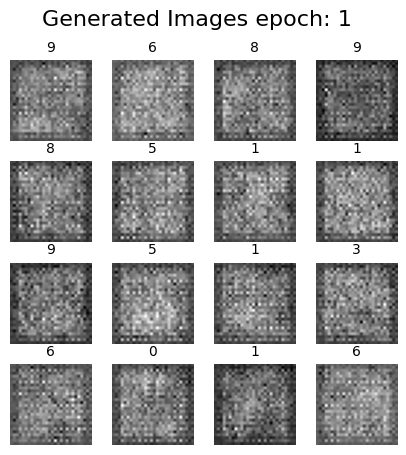

In [9]:
numImages = torch.tensor([16]).to(device)
# Generate and plot fake images with labels
labels = torch.randint(0, 10, (numImages,)).to(device)
labels_one_hot = torch.zeros(numImages, 10).to(device).scatter_(1, labels.view(numImages, 1), 1)
with torch.no_grad():
    z = torch.randn(numImages, latent_dim).to(device)
    g_input = torch.cat((z, labels_one_hot), dim=1)
    g_input = g_input.view(g_input.size(0), latent_dim + 10, 1, 1)
    fake_images = generator(g_input)
fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
label_text = [str(label.item()) for label in labels]
plt.figure(figsize=(5, 5))
for i in range(numImages):
    plt.subplot(int(numImages**0.5), int(numImages**0.5), i+1)
    plt.axis('off')
    plt.title(label_text[i], fontsize=10)
    plt.imshow(fake_images[i].cpu().squeeze(), cmap='gray')
plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.suptitle("Generated Images epoch: " + str(epoch), fontsize=16)
plt.show()